# Вариант 3
## Задание 1
Предположите с каким вероятностным законом распределен суммарный балл за экзамены. С помощью статистического теста подвержите/опровергните это предположение (первый тест - критерий согласия Колмогорова, если распределение абсолютно непрерывное, либо критерий согласия Пирсона хи-квадрат, если распределение дискретное).

### Формулировка гипотез
- $H_0$: Суммарный балл соответствует нормальному распредению
- $H_1$: Суммарный балл не соответствует нормальному распределению

### Расчет параметров распределения
- Для начала нужно просуммировать оценки за экзамены и записать их в отдельный столбец
- Затем вычислим $\mu$ (среднее): $\mu = \frac{1}{n} \sum_{i=1}^{n} x_i$
- Затем вычислим стандартное отклонение: $\sigma \sqrt{\frac{1}{n-1} \sum_{i=1}^n (x_i - \mu)^2}$

In [5]:
from scipy.stats import kstest, norm
import pandas as pd

data = pd.read_csv("exams_dataset.csv")
data['total_score'] = data['math score'] + data['reading score'] + data['writing score']
total_score = data['total_score']

mu = total_score.mean()
sigma = total_score.std()

print("Выборочное среднее: ", mu)
print("Стандартное отклонение: ", sigma)

Выборочное среднее:  202.404
Стандартное отклонение:  45.47375778013784


### Какое у нас распредение абсолютно непрерывное или дискретное?
У нас дискретное распределение, так как у нас сумма баллов за экзамен может принимать значения 0-300, при чем значения могут быть только целыми числами, поэтому распределение у нас дискретное, а следовательно, мы должны использовать критерий согласия Пирсона хи-квадрат

Чтобы построить статистику, разобьем ось на непересекающиеся отрезки (аналогично тому, как строим гистограмму):
$$- \infty < a_0 < a_1 < ... < a_r < \infty $$

Посмотрим, как отличается гистограмма от теоритического распределения. Пусть $p_i = \mathbb{P}(a_{i-1}, a_i]$. А $n_i$ - число значений выборки на том же отрезке. Рассмотрим статистику: $$ X^2 = \sum_{i=1}^r \frac{(n_i - mp_i)^2}{mp_i}$$ 

Если гипотеза верна, то статистика распределена согласно распределению $X^2(r-1)$. При известном квантиле $h_{1-\alpha}$ распредения $X^2$ критическая область будет выглядеть так: $$(h_{1 - \alpha}, \infty) $$

Если известно семейство распределений, но неизвестны параметры, то параметры можно оценить согласно методу максимальному правдоподобия. Правда, статистика будет иметь другое число степеней свободы: $X^2 \sim X^2(r-l-1)$, где l - число оцениваемых параметров.

### Разобьем данные на интервалы шириной 10 баллов:

In [6]:
import numpy as np

min_score = data["total_score"].min()
max_score = data["total_score"].max()
bins = np.arange(min_score, max_score + 10, 10)
observed, _ = np.histogram(data["total_score"], bins=bins)

### Расчитаем вероятности попадания в интервалы

In [7]:
expected = []
for i in range(len(bins) - 1):
    lower = bins[i]
    upper = bins[i + 1]
    prob = norm.cdf(upper, loc=mu, scale=sigma) - norm.cdf(lower, loc=mu, scale=sigma)
    expected.append(prob * len(data))

### Расчет статистики хи-квадрат

In [21]:
observed = np.array(observed)
expected = np.array(expected)
valid_indices = expected >= 5

observed_filtered = observed[valid_indices]
expected_filtered = expected[valid_indices]

total_observed = observed_filtered.sum()
total_expected = expected_filtered.sum()
expected_filtered = expected_filtered * (total_observed / total_expected)


chi_sq = np.sum((observed_filtered - expected_filtered) ** 2 / expected_filtered)
print(f"Статистика хи-квадрат: {chi_sq}")

Статистика хи-квадрат: 29.79790075418849


### Определение степеней свободы
$r - l - 1  =  r - 3$, где l = 2 - количество оцененных параметров $(\mu, \sigma)$ 

### Сравнение с критическим значением
Для $\alpha = 0.05$ и df = 18, критическое значение $X_{крит}^2 =  28.9$ 

In [22]:
from scipy.stats import chi2
alpha = 0.05
df =  len(expected_filtered) - 3

critical_value = chi2.ppf(1 - alpha, df)
print(f"Критическое значение (α=0.05, df={df}): {critical_value:.3f}")

Критическое значение (α=0.05, df=18): 28.869


In [19]:
from scipy.stats import chisquare
chi_stat, p_value = chisquare(observed_filtered, f_exp=expected_filtered)
print(f"Статистика хи-квадрат: {chi_stat:.3f}")
print(f"P-value: {p_value:.3f}")

Статистика хи-квадрат: 29.798
P-value: 0.073


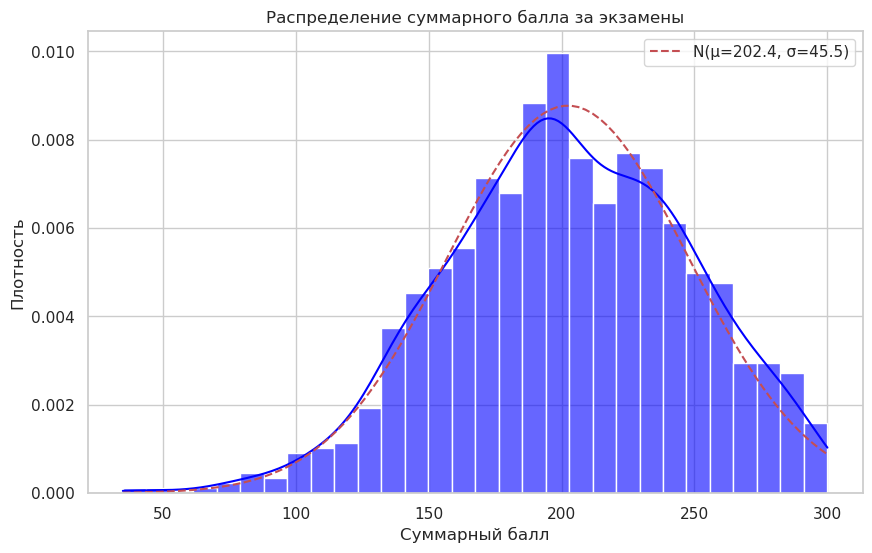

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Загрузка данных
data = pd.read_csv("exams_dataset.csv")

if "total_score" not in data.columns:
    data['total_score'] = data['math score'] + data['reading score'] + data['writing score']

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

ax = sns.histplot(data["total_score"], bins=30, kde=True, color="blue", stat="density", alpha=0.6)

# Добавление нормального распределения (если нужно)
mu = data["total_score"].mean()
sigma = data["total_score"].std()
x = np.linspace(data["total_score"].min(), data["total_score"].max(), 100)
y = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
plt.plot(x, y, "r--", label=f"N(μ={mu:.1f}, σ={sigma:.1f})")

plt.title("Распределение суммарного балла за экзамены")
plt.xlabel("Суммарный балл")
plt.ylabel("Плотность")
plt.legend()

plt.show()

### Ответ на задание №1
- Статистика хи-квадрат (29.798) > Критическое значение (28.869). Следовательно, отвергаем нулевую гипотезу $H_0$. Распределение суммарного балла не соответствует номальному распределению

## Задание 2
Верно ли, что распределение балла по математике и чтению одинаково?

### Формулировка гипотез
- $H_0$: Распределение баллов по математике и чтению одинаковы
- $H_1$: Распределение баллов по математике и чтению различны


### Критерий Колмогорова - Смирнова
Статистика теста - наибольшая возможная разница между двумя функциями распределения:
$$D = \sup_{x \in \mathbb{R}} |F_{мат}(x) - F_{чт}(x)|$$

При больших размерах выборок (m,n > 50), статистика распределена согласно протабилированному распределению Колмогорова. Критическая область следующая: 
$$(k_{1 - \alpha}, \infty)$$

Здесь $k_{\alpha}$ - квантиль распределения Колмогорова.

Нам нужно проверить гипотезу однородности. Для гипотезы однородности статистика считается таким образом:
$$D_X(X_m) = \max_{1 \leq  i \leq  m} [\frac{i}{m} - \overline{F}_{мат}(X_{(i)}),  \overline{F}_{мат}(X_{(i)}) - \frac{i-1}{m}]$$
$$D_Y(Y_n) = \max_{1 \leq  j \leq  n} [\frac{i}{n} - \overline{F}_{чт}(Y_{(j)}),  \overline{F}_{чт}(Y_{(j)}) - \frac{j-1}{n}]$$
$$D = \max(D_x, D_y)$$

Здесь $\overline{F}_{мат}$ и $\overline{F}_{чт}$ - эмпирические функции распределения соответвующих выборок.

In [36]:
math = data['math score']
reading =  data['reading score'] 

m = len(math)
n = len(reading)

combined = sorted(math + reading)

#Построим эмперические функции распределения
def ecdf(sample, x):
    return sum(1 for elem in sample if elem <= x) / len(sample)

Fm = [ecdf(math, x) for x in combined]
Gn = [ecdf(reading, x) for x in combined]

D_plus = [abs(Fm[i] - Gn[i]) for i in range(len(combined))]
D_minus = [abs(Fm[i-1] - Gn[i]) for i in range(1, len(combined))]
D = max(max(D_plus), max(D_minus))

### Определение критического значения
Критическое значение $D_{крит}$ для уровня значимости $\alpha = 0.05$ рассчитывается по формуле:
$$D_{крит} = c(a)\sqrt{\frac{n + m}{n * m}},$$ где c(a) = 1.36 для $\alpha = 0.05$

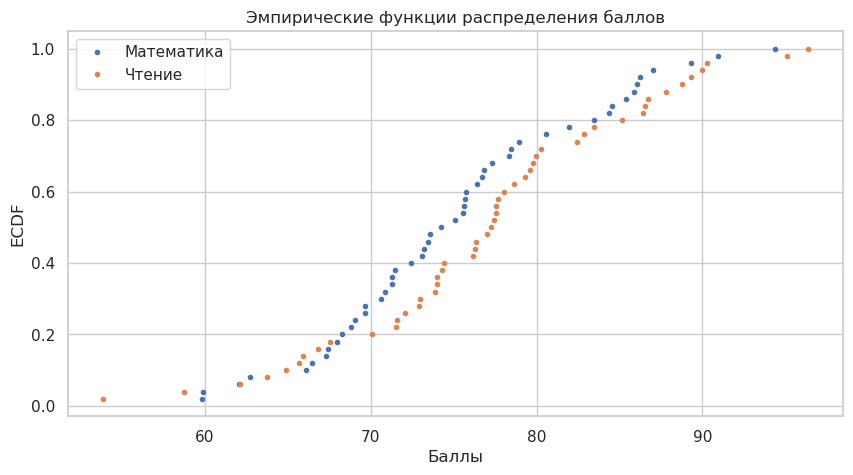

In [38]:
from math import sqrt
D_crit = 1.36 * sqrt((n + m)/(n*m))

import matplotlib.pyplot as plt
import numpy as np

# Пример данных
math_scores = np.random.normal(75, 10, 50)
reading_scores = np.random.normal(78, 8, 50)

# Построение ECDF
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

x_math, y_math = ecdf(math_scores)
x_reading, y_reading = ecdf(reading_scores)

plt.figure(figsize=(10, 5))
plt.plot(x_math, y_math, label="Математика", marker=".", linestyle="none")
plt.plot(x_reading, y_reading, label="Чтение", marker=".", linestyle="none")
plt.xlabel("Баллы")
plt.ylabel("ECDF")
plt.legend()
plt.title("Эмпирические функции распределения баллов")
plt.show()

In [33]:
print(f"Статистика критерия: {D}")
print(f"Критическое значение: {D_crit}")

Статистика критерия: 0.099
Критическое значение: 0.060821048987994286


### Ответ
Поскольку D = 0.099 > D_crit = 0.608, отвергаем нулевую гипотезу $H_0$

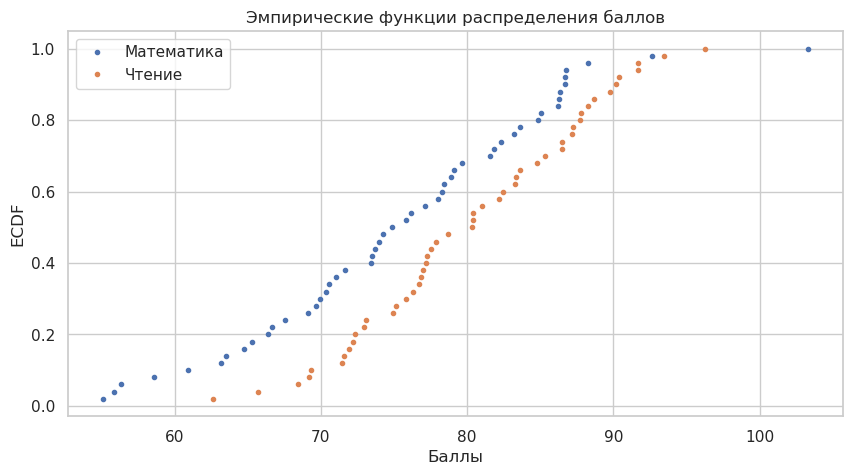

### Программный критерий $X^2$

In [47]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Загрузка данных
data = pd.read_csv("exams_dataset.csv")
math = data["math score"]
reading = data["reading score"]

bins = np.arange(0, 101, 10)  # [0, 10, 20, ..., 100]
labels = [f"{i}-{i+9}" for i in bins[:-1]]

math_binned = pd.cut(math, bins=bins, labels=labels)
reading_binned = pd.cut(reading, bins=bins, labels=labels)

contingency_table = pd.crosstab(math_binned, reading_binned)
contingency_table.loc["0-19"] = contingency_table.loc["0-9"] + contingency_table.loc["10-19"]
contingency_table = contingency_table.drop(["0-9", "10-19"])
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
from scipy.stats import chi2

alpha = 0.05
critical_value = chi2.ppf(1 - alpha, dof)
print(f"Критическое значение (α=0.05): {critical_value:.3f}")

print(f"Статистика хи-квадрат: {chi2_stat:.3f}")
print(f"P-value: {p_value:.3f}")
print(f"Степени свободы: {dof}")

Критическое значение (α=0.05): 83.675
Статистика хи-квадрат: 1519.332
P-value: 0.000
Степени свободы: 64


### Критерий $X^2$
Подверждает критерий Колмогорова - Смирного. Данный критерий также отвергает нулевую гипотезу

## Задание №3
Верно ли, что прослушавшие подготовительные курсы лучше сдали экзамены?

### Формулировка гипотез
- $H_0$: Нет корреляции между прохождением подготовительных курсов и баллами за экзамены (r = 0)
- $H_1$: Существует положительная корреляция (r > 0).

### Выбор коэффициента корреляции
Используем коэффициент корреляции Пирсона, так как:
- Одна переменная бинарная (курсы: 1 - прошел, 0 - не прошел)
- Вторая переменная количественная (сумма баллов за экзамены)

### Расчет коэффициента Пирсона
Формула:
$$r = \frac{\sum{(x_i - \overline{x})(y_i - \overline{y})}}{\sqrt{\sum{(x_i - \overline{x})^2} \sum{(y_i - \overline{y})^2}}},$$
где 
- $x_i$ - бинарная переменная (прохождение курсов)
- $y_i$ - сумма баллов за экзамены

### Используем t-тест для коэффициента Пирсона
$$ t = \frac{r \sqrt{n - 2}}{\sqrt{1 - r^2}},$$
где n - количество студентов

Коэффициент Пирсона: 0.25924975442185866


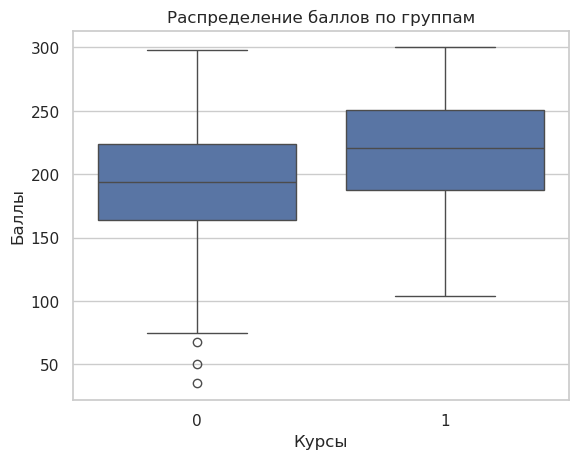

In [58]:
import pandas as pd
from scipy.stats import pearsonr

# Загрузка данных
data = pd.read_csv("exams_dataset.csv")
courses = data["test preparation course"].map({"completed": 1, "none": 0})
data['total_score'] = data['math score'] + data['reading score'] + data['writing score']
total_score = data['total_score']

x_overline = np.mean(courses)
y_overline = np.mean(total_score)

sum_1 = 0
sum_2 = 0
sum_3 = 0
for i in range(len(total_score)):
    sum_1 += ((courses[i] - x_overline) *(total_score[i] - y_overline))
    sum_2 += (courses[i] - x_overline)**2
    sum_3 += (total_score[i] - y_overline)**2

r = (sum_1) / sqrt(sum_2 * sum_3)
print(f"Коэффициент Пирсона: {r}")

sns.boxplot(x=courses, y=total_score)
plt.title("Распределение баллов по группам")
plt.xlabel("Курсы")
plt.ylabel("Баллы")
plt.show()

### Ответ
Коэффициент Пирсона r = 0.26, следовательно у нас есть слабая положительная связь между переменными. Проверим это с помощью еще одного коэффициента корреляции. 

### Коэффициент Спирмена

In [60]:
from scipy.stats import spearmanr

rho, p_value_spearman = spearmanr(courses, total_score)
print(f"Коэффициент Спирмена: {rho:.3f}")

Коэффициент Спирмена: 0.251


Как видим результат сошелся